## Variational Auto-Encoders


In [ ]:
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118

if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm


%matplotlib inline
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from matplotlib import gridspec

Looking in indexes: https://download.pytorch.org/whl/cu118


Hyper-Parameters
----------------

In [2]:
batch_size = 3000     # batch size
latent_dim = 100      # latent-space dimension
middle_dim = 128      # size of the middle layer
learning_rate = 1e-3  # learning rate
max_epochs = 50       # maximum number of epochs
use_gpu = True        # using the GPU

Loading the Dataset
-------------------
As in the GAN example, we will be using the MNIST dataset. MNIST images show digits from 0-9 in 28x28 grayscale images.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.ToTensor()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# image dimensions
input_dim = 28**2

100%|██████████| 9912422/9912422 [00:00<00:00, 94345946.41it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101199410.05it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36421089.37it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21648328.15it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



VAE Definition
--------------
We will now use a specific scheme to initialize our weights, called Xavier initialization. You can neglect this if you are using other layers than fully connected.

In [4]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

The following model represents the distribution encoder distribution q(z|x), together with the reparametrization trick.

In [5]:
class Q(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(Q, self).__init__()
    self.lin_middle = nn.Linear(input_dim, middle_dim, bias=True)
    self.lin_mu = nn.Linear(middle_dim, latent_dim, bias=True)
    self.lin_var = nn.Linear(middle_dim, latent_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_middle)
    init_weights(self.lin_mu)
    init_weights(self.lin_var)

  def forward(self, input):
    # forward
    middle = F.relu(self.lin_middle(input))
    z_mu = self.lin_mu(middle)
    z_var = self.lin_var(middle)
    return z_mu, z_var

We now model the reparametrization trick.

In [6]:
class Reparametrization(nn.Module):
  def __init__(self):
    super(Reparametrization, self).__init__()

  def forward(self, z_mu, z_var):
    eps = torch.randn(z_var.size(0), z_var.size(1), device=device) # sample on a unit Gaussian
    return z_mu + torch.exp(z_var/2) * eps

The following model represents the decoder P(x|z).

In [7]:
class P(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(P, self).__init__()
    self.lin_latent = nn.Linear(latent_dim, middle_dim, bias=True)
    self.lin_middle = nn.Linear(middle_dim, input_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_latent)
    init_weights(self.lin_middle)

  def forward(self, latent):
    middle = F.relu(self.lin_latent(latent))
    return F.sigmoid(self.lin_middle(middle))

Training
--------

We first initialize an instance of the model and load it onto GPU if relevant.

In [8]:
# creating instances of the model
p = P(input_dim, middle_dim, latent_dim)
q = Q(input_dim, middle_dim, latent_dim)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the GPU (faster).
Number of parameters for encoder: 114064 and decoder: 126280


We can now do the training properly speaking.

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training...


Epoch 0: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


	[Losses] Total 1.37 - Recon. 1.28 - KL 0.0833


Epoch 1: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


	[Losses] Total 1.25 - Recon. 1.15 - KL 0.0996


Epoch 2: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


	[Losses] Total 1.17 - Recon. 1.06 - KL 0.112


Epoch 3: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


	[Losses] Total 1.13 - Recon. 1.01 - KL 0.115


Epoch 4: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


	[Losses] Total 1.09 - Recon. 0.973 - KL 0.117


Epoch 5: 100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


	[Losses] Total 1.06 - Recon. 0.944 - KL 0.12


Epoch 6: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


	[Losses] Total 1.04 - Recon. 0.92 - KL 0.124


Epoch 7: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


	[Losses] Total 1.02 - Recon. 0.895 - KL 0.128


Epoch 8: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


	[Losses] Total 1.01 - Recon. 0.876 - KL 0.131


Epoch 9: 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


	[Losses] Total 0.992 - Recon. 0.858 - KL 0.135


Epoch 10: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


	[Losses] Total 0.982 - Recon. 0.844 - KL 0.138


Epoch 11: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


	[Losses] Total 0.972 - Recon. 0.831 - KL 0.141


Epoch 12: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


	[Losses] Total 0.963 - Recon. 0.82 - KL 0.143


Epoch 13: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


	[Losses] Total 0.956 - Recon. 0.811 - KL 0.145


Epoch 14: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


	[Losses] Total 0.95 - Recon. 0.802 - KL 0.148


Epoch 15: 100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


	[Losses] Total 0.944 - Recon. 0.794 - KL 0.15


Epoch 16: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


	[Losses] Total 0.937 - Recon. 0.786 - KL 0.151


Epoch 17: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


	[Losses] Total 0.935 - Recon. 0.782 - KL 0.153


Epoch 18: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


	[Losses] Total 0.928 - Recon. 0.774 - KL 0.154


Epoch 19: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 0.923 - Recon. 0.767 - KL 0.156


Epoch 20: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


	[Losses] Total 0.918 - Recon. 0.761 - KL 0.157


Epoch 21: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 0.913 - Recon. 0.754 - KL 0.159


Epoch 22: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


	[Losses] Total 0.909 - Recon. 0.748 - KL 0.16


Epoch 23: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


	[Losses] Total 0.906 - Recon. 0.745 - KL 0.161


Epoch 24: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


	[Losses] Total 0.902 - Recon. 0.739 - KL 0.163


Epoch 25: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


	[Losses] Total 0.894 - Recon. 0.731 - KL 0.163


Epoch 26: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


	[Losses] Total 0.894 - Recon. 0.729 - KL 0.165


Epoch 27: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


	[Losses] Total 0.889 - Recon. 0.723 - KL 0.166


Epoch 28: 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


	[Losses] Total 0.886 - Recon. 0.719 - KL 0.167


Epoch 29: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


	[Losses] Total 0.879 - Recon. 0.712 - KL 0.167


Epoch 30: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


	[Losses] Total 0.878 - Recon. 0.709 - KL 0.168


Epoch 31: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


	[Losses] Total 0.873 - Recon. 0.704 - KL 0.169


Epoch 32: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


	[Losses] Total 0.87 - Recon. 0.7 - KL 0.17


Epoch 33: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


	[Losses] Total 0.865 - Recon. 0.695 - KL 0.17


Epoch 34: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


	[Losses] Total 0.863 - Recon. 0.693 - KL 0.171


Epoch 35: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


	[Losses] Total 0.86 - Recon. 0.689 - KL 0.171


Epoch 36: 100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


	[Losses] Total 0.853 - Recon. 0.682 - KL 0.171


Epoch 37: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


	[Losses] Total 0.853 - Recon. 0.682 - KL 0.172


Epoch 38: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


	[Losses] Total 0.847 - Recon. 0.675 - KL 0.172


Epoch 39: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


	[Losses] Total 0.845 - Recon. 0.673 - KL 0.172


Epoch 40: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


	[Losses] Total 0.843 - Recon. 0.671 - KL 0.172


Epoch 41: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


	[Losses] Total 0.837 - Recon. 0.665 - KL 0.172


Epoch 42: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


	[Losses] Total 0.833 - Recon. 0.661 - KL 0.172


Epoch 43: 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


	[Losses] Total 0.832 - Recon. 0.66 - KL 0.172


Epoch 44: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


	[Losses] Total 0.827 - Recon. 0.655 - KL 0.173


Epoch 45: 100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


	[Losses] Total 0.826 - Recon. 0.653 - KL 0.173


Epoch 46: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


	[Losses] Total 0.822 - Recon. 0.65 - KL 0.172


Epoch 47: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


	[Losses] Total 0.818 - Recon. 0.645 - KL 0.173


Epoch 48: 100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


	[Losses] Total 0.817 - Recon. 0.645 - KL 0.173


Epoch 49: 100%|██████████| 20/20 [00:05<00:00,  3.39it/s]

	[Losses] Total 0.813 - Recon. 0.641 - KL 0.173
Done.


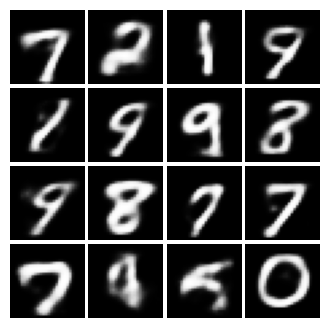

In [12]:
p.train()
q.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.5, 0.999))
bce = nn.BCELoss(size_average=False, reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):

  avg_total_loss = 0
  avg_recon_loss = 0
  avg_kl_loss = 0

  for _, (batch, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
    batch = batch.to(device) # load the data onto GPU is relevant
    batch = batch.view(batch_size, -1)

    # forward
    z_mu, z_var = q(batch)
    z = reparam(z_mu, z_var)
    batch_recon = p(z)

    # reconstruction loss E[log P(X|z)]
    recon_loss = bce(batch_recon, batch) / len(batch)
    # distribution loss D_KL(Q(z|X) || P(z))
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
    # Total loss
    total_loss = recon_loss + kl_loss

    # backward
    total_loss.backward()

    # update
    optim.step()

    # housekeeping
    optim.zero_grad()
    avg_total_loss += total_loss / len(batch)
    avg_recon_loss += recon_loss / len(batch)
    avg_kl_loss += kl_loss / len(batch)

  # end of epoch
  total_losses.append(avg_total_loss.item())
  recon_losses.append(avg_recon_loss.item())
  kl_losses.append(avg_kl_loss.item())
  print(f"\t[Losses] Total {total_losses[-1]:.3} - Recon. {recon_losses[-1]:.3} - KL {kl_losses[-1]:.3}")

  # plot
  if epoch % 2 == 0:
        samples = p(z).data.cpu().numpy()[:16]

        plt.close()
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('training/') and not os.path.exists('out/'):
            os.makedirs('out/')
        # plt.show()
        # plt.pause(0.1)
        # plt.savefig('training/{}_{}.png'.format(epoch, str(current_image).zfill(3)), bbox_inches='tight')
        current_image += 1
        # plt.close(fig)

print("Done.")

We can now plot the training curves.

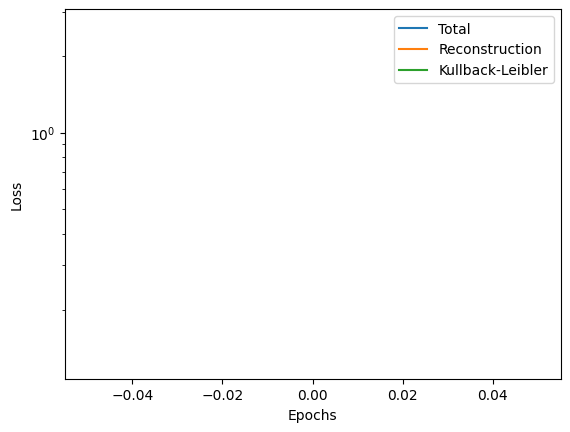

In [10]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generation
----------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**2, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**2, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = correct_shape(fake_image_batch)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

Visualization in Latent Space
-----------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()

def correct_shape(imgs):
  return imgs.view(-1, 28, 28).unsqueeze(1)

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn((1, latent_dim), device=device)
latent_2 = torch.randn((1, latent_dim), device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), p, latent_1, latent_2)

    inter_image = correct_shape(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()